In [1]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from spring_rods_system_setup import SpringRodsSystemSetup
from spring_rods_system_with_penalization_setup import SpringRodSystemWithPenalizationSetup
from spring_rods_system_solver import SpringRodsSystemSolver
from utils.computational_utils import l2_norm
from utils.plot_utils import plot_displacements_and_stress

In [2]:
plt.rcParams.update({
    'axes.grid': True,
    'figure.facecolor': 'white',
    'mathtext.default': 'regular',
})

In [3]:
model_setup = {
    'interval': (-1, 1),
    'spring_len': 1,
    'step_size': 1/256,
    'material_const': (1, 1),
    'spring_const': (1, 1),
}

In [4]:
def penalize_compression_func(x: Tuple[np.ndarray, np.ndarray]):
    spring_len = model_setup['spring_len']
    theta = spring_len - x[0][-1] + x[1][0]
    # This is specific for looking for a solution with assumption of spring extension
    if theta >= spring_len:
        return 0
    return (spring_len - theta) ** 2


def penalize_extension_func(x: Tuple[np.ndarray, np.ndarray]):
    spring_len = model_setup['spring_len']
    theta = spring_len - x[0][-1] + x[1][0]
    # This is specific for looking for a solution with assumption of spring extension
    if theta <= spring_len:
        return 0
    return (spring_len - theta) ** 2

In [5]:
experiment_definitions = [
    {
        'body_forces': lambda x: np.where(x < 0, 1, -1), # forces that causes compression
        'penalization_func': penalize_compression_func,
        'spring_len_bounds':(-np.inf, 0) # the constraint that doesn't allow the spring to compress
    },
    {
        'body_forces': lambda x: np.where(x < 0, -1, 1), # forces that causes extension
        'penalization_func': penalize_extension_func,
        'spring_len_bounds':(0, model_setup['spring_len']) # the constraint that doesn't allow the spring to extend
    }
]

In [6]:
experiment_setup = experiment_definitions[0]

In [7]:
model = SpringRodsSystemSetup(
    **model_setup,
    body_forces=experiment_setup['body_forces']
)
solver = SpringRodsSystemSolver(
    model,
    spring_len_bounds=experiment_setup['spring_len_bounds']
)
constrained_solution = solver()

In [8]:
penalized_model = SpringRodSystemWithPenalizationSetup(
    **model_setup,
    body_forces=experiment_setup['body_forces'],
    penalization_function=experiment_setup['penalization_func'],
    penalization_const=1 # this is going to be overwritten
)
solver = SpringRodsSystemSolver(penalized_model)

In [9]:
inverse_penal_params = np.array([1 << x for x in range(14)])

In [10]:
print(inverse_penal_params)

[   1    2    4    8   16   32   64  128  256  512 1024 2048 4096 8192]


In [11]:
cmap = plt.get_cmap('viridis', inverse_penal_params.size)

14it [01:03,  4.52s/it]


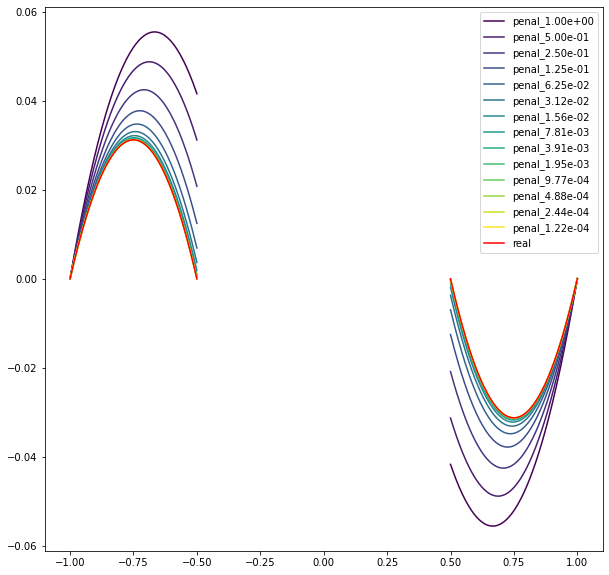

In [12]:
fig = plt.gcf()
fig.set_size_inches(10, 10)

error_norm = []

for idx, inv_penal in tqdm(enumerate(inverse_penal_params)):
    penalized_model.penalization_const = 1 / inv_penal
    solution = solver()

    err = tuple(solution[side] - constrained_solution[side] for side in (0, 1))
    error_norm.append(l2_norm(values=err, domain=model.domain))

    plt.plot(penalized_model.domain[0], solution[0], color=cmap(idx), label=f'penal_{1 / inv_penal:.2e}')
    plt.plot(penalized_model.domain[1], solution[1], color=cmap(idx))

plt.plot(model.domain[0], constrained_solution[0], color='red', label='real')
plt.plot(model.domain[1], constrained_solution[1], color='red')

plt.legend()
plt.grid()

([<matplotlib.axis.YTick at 0x7f8511236970>,
 [Text(0, 1.1746210969555076e-05, '1.17e-05'),
  Text(0, 8.80967295829239e-06, '8.81e-06'),
  Text(0, 5.873146229784339e-06, '5.87e-06'),
  Text(0, 3.5239152442083215e-06, '3.52e-06'),
  Text(0, 1.957767300064883e-06, '1.96e-06'),
  Text(0, 1.0364623697545017e-06, '1.04e-06'),
  Text(0, 5.33817379497986e-07, '5.34e-07'),
  Text(0, 2.710656381581506e-07, '2.71e-07'),
  Text(0, 1.365874183024766e-07, '1.37e-07'),
  Text(0, 6.861253092255469e-08, '6.86e-08'),
  Text(0, 3.455549606092642e-08, '3.46e-08'),
  Text(0, 1.768034506626051e-08, '1.77e-08'),
  Text(0, 1.0684608843825525e-08, '1.07e-08'),
  Text(0, 7.1275262504809614e-09, '7.13e-09')])

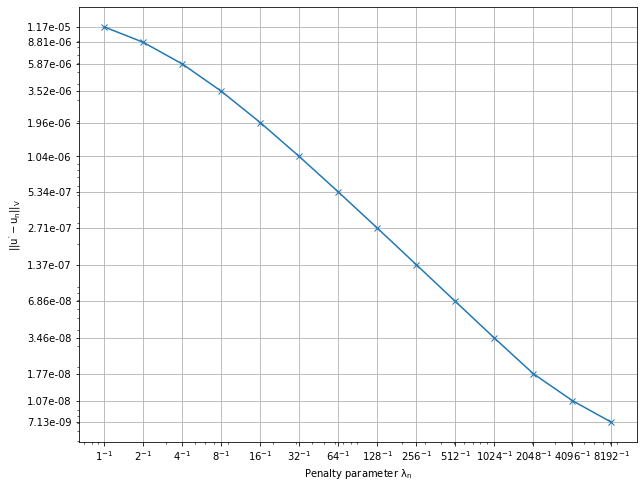

In [13]:
fig = plt.gcf()
fig.set_size_inches(10, 8)

plt.plot(inverse_penal_params, error_norm, marker='x')
plt.xlabel('Penalty parameter $\lambda_n$')
plt.ylabel('$||u\' - u_n||_V$')
plt.xscale('log')
plt.yscale('log')

plt.xticks(inverse_penal_params, [f'${{{q}}}^{{-1}}$' for q in inverse_penal_params])

plt.yticks(error_norm, [f'{err:.2e}' for err in error_norm])